# Enron Fraud Indentification

The main purpose of this project is using machine learning algorithm to detect fraudsters. Those persons are main criminals in Enron scandal. We would like to make a learning model to predict those people by using multiple variables which are reported in financial sheets and emailling list. Because we have already know person of interests (POI), we could use supervised machine learning to do this task. 

In [1]:
#!/usr/bin/python

import sys
import pickle
sys.path.append("../tools/")
import tester

import tester
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from time import time
from sklearn.cross_validation import train_test_split
from sklearn import linear_model
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from tabulate import tabulate
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedShuffleSplit

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn.linear_model import LogisticRegression
from xgboost.sklearn import XGBClassifier
import xgboost as xgb

%matplotlib inline 

## 1. Dataset Exploration

In [2]:
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

In [3]:
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
target_list = ['poi']
report_list = ['salary','deferral_payments', 'total_payments',
               'loan_advances', 'bonus', 'restricted_stock_deferred', 
               'deferred_income', 'total_stock_value', 'expenses',
               'exercised_stock_options', 'other', 'long_term_incentive', 
               'restricted_stock', 'director_fees','to_messages',
               'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 
               'shared_receipt_with_poi']
features_list =  target_list + report_list

In [4]:
### Store to my_dataset for easy export below.
my_dataset = data_dict
counter = 0
for entry in my_dataset:
    if my_dataset[entry]['poi']:
        counter += 1

In [5]:
print 'Number of data points in this dataset: %f' %len(my_dataset)
print 'Number of POI in this dataset: %f' %counter
print 'Number of feature in this dataset: %f' %len(features_list)

Number of data points in this dataset: 146.000000
Number of POI in this dataset: 18.000000
Number of feature in this dataset: 20.000000


There are total 18 POIs in total 146 data points. Next step will be the data auditing to determine missing values or outliers.

### Data audit

In [6]:
### Determine missing values in Enron report
value_report_list = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
dict_report_list = dict(zip(report_list,value_report_list))
for entry in my_dataset:
    for name in report_list:
        val = my_dataset[entry][name]
        if val == 'NaN':
            dict_report_list[name] += 1
NaN_table = pd.DataFrame(dict_report_list.items(), columns=['Feature', 'No of Missing Values'])
print NaN_table.sort(columns = 'No of Missing Values',ascending=False)

                      Feature  No of Missing Values
11              loan_advances                   142
6               director_fees                   129
7   restricted_stock_deferred                   128
2           deferral_payments                   107
15            deferred_income                    97
18        long_term_incentive                    80
5                       bonus                    64
16    shared_receipt_with_poi                    60
14    from_this_person_to_poi                    60
1                 to_messages                    60
10    from_poi_to_this_person                    60
12              from_messages                    60
13                      other                    53
0                      salary                    51
9                    expenses                    51
4     exercised_stock_options                    44
17           restricted_stock                    36
3              total_payments                    21
8           

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:10: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


Through above table, every features except 'poi' has missing values at least 20 times. Top 3 features that have highest missing values are 'loan_advance', 'director_fees' and 'restricted_stock_deferred'. 

According to Enron printed sheet, I found two outlier that is "TOTAL" and "THE TRAVEL AGENCY IN THE PARK". 
- "TOTAL" is the summary of every column in Enron sheet and it is a spreadsheet quirk.
- "THE TRAVEL AGENCY IN THE PARK" is the account of business-related travel to The Travel Agency in the Park. It is not a person of interest.

Another possibility is the observation with no information (all "NaN" value) which will determined by the script beblow.

In [7]:
outlier_list = []
#### Next script is used to remove observation which have all value 'NaN' in Enron report. 
for entry in my_dataset:
    for name in report_list:
        val = my_dataset[entry][name]
        if val == 'NaN':
            if entry not in outlier_list:
                outlier_list.append(entry)
        elif val != 'NaN':
            try:
                outlier_list.remove(entry)
                break
            except ValueError:
                break

outlier_list.append('TOTAL') #insert 'TOTAL' observation
outlier_list.append('THE TRAVEL AGENCY IN THE PARK')
print 'The outlier list is: '
print outlier_list

The outlier list is: 
['LOCKHART EUGENE E', 'TOTAL', 'THE TRAVEL AGENCY IN THE PARK']


### Remove outlier

In [8]:
#### Remove outlier
for name in outlier_list:
    my_dataset.pop(name,0)
print 'Number of data points after outlier removing in this dataset: %f' %len(my_dataset)

Number of data points after outlier removing in this dataset: 143.000000


## 2. Feature Selection

### Create new feature

Through the Enron report, we have the email list of Enron POI and non-POI. It will be smart to create a new feature based on the ratio between to/from POI and to/from a person. There is a chance that they can be used in POI prediction later.

In [9]:
#### Making new feature based on other features.
def computeFraction( poi_messages, all_messages ):
    """ given a number messages to/from POI (numerator) 
        and number of all messages to/from a person (denominator),
        return the fraction of messages to/from that person
        that are from/to a POI
   """
   
    ### you fill in this code, so that it returns either
    ###     the fraction of all messages to this person that come from POIs
    ###     or
    ###     the fraction of all messages from this person that are sent to POIs
    ### the same code can be used to compute either quantity

    ### beware of "NaN" when there is no known email address (and so
    ### no filled email features), and integer division!
    ### in case of poi_messages or all_messages having "NaN" value, return 0.
    if poi_messages == "NaN":
        fraction = 0.
    elif all_messages == "NaN":
        fraction = 0.
    else:
        fraction = poi_messages*1.0/all_messages

    return fraction

for name in my_dataset:
    data_point = my_dataset[name]
    from_poi_to_this_person = data_point["from_poi_to_this_person"]
    to_messages = data_point["to_messages"]
    fraction_from_poi = computeFraction( from_poi_to_this_person, to_messages )
    my_dataset[name]["fraction_from_poi"] = fraction_from_poi

    from_this_person_to_poi = data_point["from_this_person_to_poi"]
    from_messages = data_point["from_messages"]
    fraction_to_poi = computeFraction( from_this_person_to_poi, from_messages )
    my_dataset[name]["fraction_to_poi"] = fraction_to_poi

### Feature list with addtional features
features_list = features_list + ['fraction_from_poi','fraction_to_poi']
print features_list

['poi', 'salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees', 'to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi', 'fraction_from_poi', 'fraction_to_poi']


### Feature selection

In order to determine the best features for prediction, I have used 'SelectKBest' function to evaluate the importance of each features. The function was applied in training set created by 'train_test_split' function.

In [10]:
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

In [11]:
### Using SelectKBest to determine number of selection feature.
SKB = SelectKBest()
SKB.fit(features,labels)
scores = SKB.scores_
unsorted_pairs = zip(features_list[1:], scores)
sorted_pairs = list(reversed(sorted(unsorted_pairs, key=lambda x: x[1])))
KBest_table = pd.DataFrame(sorted_pairs,columns=['Feature','Score'])
print KBest_table

                      Feature      Score
0     exercised_stock_options  24.815080
1           total_stock_value  24.182899
2                       bonus  20.792252
3                      salary  18.289684
4             fraction_to_poi  16.409713
5             deferred_income  11.458477
6         long_term_incentive   9.922186
7            restricted_stock   9.212811
8              total_payments   8.772778
9     shared_receipt_with_poi   8.589421
10              loan_advances   7.184056
11                   expenses   6.094173
12    from_poi_to_this_person   5.243450
13                      other   4.187478
14          fraction_from_poi   3.128092
15    from_this_person_to_poi   2.382612
16              director_fees   2.126328
17                to_messages   1.646341
18          deferral_payments   0.224611
19              from_messages   0.169701
20  restricted_stock_deferred   0.065500


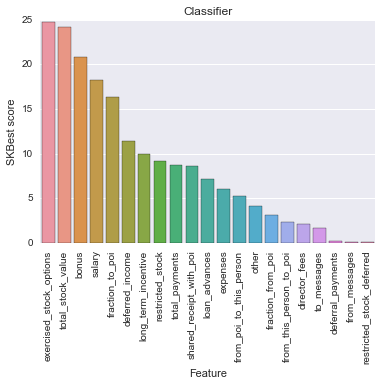

In [12]:
sns.barplot(KBest_table['Feature'],KBest_table['Score'])
_, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.ylabel('SKBest score')
plt.title('Classifier')
plt.show()

According to the result of SelectKBest, I selected 6 features of interest since they have highest impact for the model fitting (score > 10). Clearly, we see that our new feature "fraction_to_poi" has high impact on the data model when it is at top 5th. Would this enginereed variable affect the validation of POIs in classifer ? To answer this question, I made an classifer testing with two feature lists: original list (without 'fraction_to_poi') and engineered list (with 'fraction_to_poi').

In [13]:
### Validate the original feature list in Naive Bayes classifier
old_features_list = target_list + list(KBest_table['Feature'].iloc[:6])
old_features_list.remove('fraction_to_poi')
print old_features_list
# Re-create the data for model fitting
data = featureFormat(my_dataset, old_features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
# Example starting point. Create train and test set from original dataset. 30% of data goes into test set.
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)
    
clf_NB = GaussianNB()
clf_NB.fit(features_train,labels_train)
labels_pred = clf_NB.predict(features_test)
print classification_report(labels_test, labels_pred)

['poi', 'exercised_stock_options', 'total_stock_value', 'bonus', 'salary', 'deferred_income']
             precision    recall  f1-score   support

        0.0       0.95      0.95      0.95        39
        1.0       0.33      0.33      0.33         3

avg / total       0.90      0.90      0.90        42



In [14]:
### Validate the engineered feature list in Naive Bayes classifier
new_features_list = target_list + list(KBest_table['Feature'].iloc[:6])
print new_features_list
# Re-create the data for model fitting
data = featureFormat(my_dataset, new_features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
# Example starting point. Create train and test set from original dataset. 30% of data goes into test set.
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)
    
clf_NB = GaussianNB()
clf_NB.fit(features_train,labels_train)
labels_pred = clf_NB.predict(features_test)
print classification_report(labels_test, labels_pred)

['poi', 'exercised_stock_options', 'total_stock_value', 'bonus', 'salary', 'fraction_to_poi', 'deferred_income']
             precision    recall  f1-score   support

        0.0       0.92      0.94      0.93        36
        1.0       0.60      0.50      0.55         6

avg / total       0.87      0.88      0.88        42



The precision and recall scores of my engineered list is higher than original list in POI detection (class 1). So I suggested to include 'fraction_to_poi' in feature set used for further investigation.

In [15]:
print tabulate([['Original List', 0.33, 0.33], ['Engineered list', 0.60, 0.50]], headers=['Name', 'Precision','Recall'])

Name               Precision    Recall
---------------  -----------  --------
Original List           0.33      0.33
Engineered list         0.6       0.5


In [16]:
data = featureFormat(my_dataset, new_features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
# Example starting point. Create train and test set from original dataset. 30% of data goes into test set.
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

In [17]:
#### Reshape the training and test sets.
features_train = np.array(features_train)
labels_train = np.array(labels_train)
features_test = np.array(features_test)
labels_test = np.array(labels_test)

## 3. Evaluation of classifiers

There are many classifiers for classification. For the purpose of this porject and time saving, I only picked 6 common models for data fitting. I created pipeline that includes Scaling, Feature Selection, Principle Component Analysis (PCA) and Classifiers. I had to use feature scaling because some model need that processing.

Through running defaut model with 6 features of interest, their 'f1' scores were compared after running 'tester.py' . The reason for chosing 'f1' because it is the weighted average of Precision and Recall.

In [18]:
### Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

#### Checking the final result with all ML that are used for classification:
#### Using GridSearchCV to optimize number of features + SelectKBest
#### Create cross-validation  
sss = StratifiedShuffleSplit(labels_train, 50, test_size = 0.3, random_state = 42)
mm_scaler = MinMaxScaler()

name_list = ['Naive Bayes',
             'Support Vector Machine',
             'Decision Tree',
             'KNN',
             'RandomForest','AdaBoost'
            ]
clf_list = [GaussianNB(),
            SVC(),
            DecisionTreeClassifier(),
            KNeighborsClassifier(),
            RandomForestClassifier(),
            AdaBoostClassifier()
           ]

for name, clf in zip(name_list,clf_list):
    t0 = time() 
    pipe = Pipeline(steps =[('scaler',mm_scaler),('SKB',SelectKBest(k = 6)),('CLF',clf)])
    pipe.fit(features_train,labels_train)
    labels_pred = pipe.predict(features_test)
    clf_final = pipe
    #clf_final = pipe
    print '\t'
    print name
    print 'Fit to training dataset'
    print classification_report(labels_test, labels_pred)    
    print '\t'
    print 'Test on tester.py'
    f1 = tester.test_classifier(clf_final, my_dataset, new_features_list)
    print f1
    print "done in %0.3fs" % (time() - t0)

	
Naive Bayes
Fit to training dataset
             precision    recall  f1-score   support

        0.0       0.92      0.92      0.92        36
        1.0       0.50      0.50      0.50         6

avg / total       0.86      0.86      0.86        42

	
Test on tester.py
Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('SKB', SelectKBest(k=6, score_func=<function f_classif at 0x0000000007B63F98>)), ('CLF', GaussianNB())])
	Accuracy: 0.85236	Precision: 0.47723	Recall: 0.35100	F1: 0.40449	F2: 0.37061
	Total predictions: 14000	True positives:  702	False positives:  769	False negatives: 1298	True negatives: 11231

None
done in 2.235s
	
Support Vector Machine
Fit to training dataset
             precision    recall  f1-score   support

        0.0       0.86      1.00      0.92        36
        1.0       0.00      0.00      0.00         6

avg / total       0.73      0.86      0.79        42

	
Test on tester.py


C:\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Got a divide by zero when trying out: Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('SKB', SelectKBest(k=6, score_func=<function f_classif at 0x0000000007B63F98>)), ('CLF', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
Precision or recall may be undefined due to a lack of true positive predicitons.
None
done in 2.101s
	
Decision Tree
Fit to training dataset
             precision    recall  f1-score   support

        0.0       0.91      0.89      0.90        36
        1.0       0.43      0.50      0.46         6

avg / total       0.84      0.83      0.84        42

	
Test on tester.py
Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('SKB', SelectKBest(k=6, score_func=<function f_classif at 0x0000000007B63F98>)), ('CLF', DecisionTreeClassifier(class_

### Visualization of F1 scores

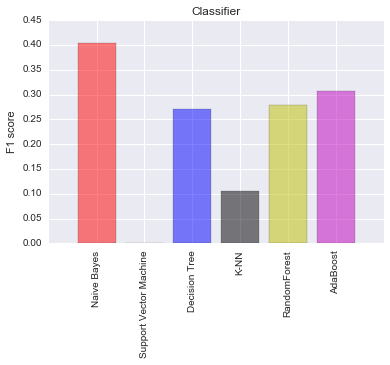

In [19]:
### Create array for f1
f1_score = [0.40449,0.0,0.27005,0.10543,0.27834,0.30765]

name_list = ('Naive Bayes','Support Vector Machine',
             'Decision Tree','K-NN',
             'RandomForest','AdaBoost')

plt.bar(np.arange(len(name_list)),f1_score,align='center', color = 'rgbkymc',alpha = 0.5)
plt.xticks(np.arange(len(name_list)), name_list, rotation = 90)
plt.ylabel('F1 score')
plt.title('Classifier')
plt.show()

I found that Naive Bayes model had the highest F1-score. I decided to select Naive Bayes and Decision Tree for my model optimization. The final model is the one which highest F1 after parameter tuning.

## 4. Model optimization

The objective of this task is trying to optimize model fitting in order to obtain at least 0.3 in both precision and recall using testing script. 

The strategy for tuning is using GridSearchCV to optimize parameters from each models and apply cross-validation to determine the best F1 score.

### 4.1 Naive Bayes

My strategy is to optimize:
- The number of features: SelectKBest(k = 5,6)
- The number of components: PCA(n_components = 2,3,4)

In [20]:
### Create cross-validation
sss = StratifiedShuffleSplit(labels, 50, random_state = 42)

In [21]:
t0 = time()
# PCA
pca = PCA()
#Pipeline
pipeline = Pipeline([('scale',mm_scaler),('SKB',SelectKBest()),('PCA',PCA()),('NB', GaussianNB())])
# clf's parameters
parameters = {'SKB__k':[5,6],
              'PCA__n_components':[2,3,4]
             }
#GridSearchCV
gs = GridSearchCV(pipeline, parameters, cv=sss, scoring='f1')
gs.fit(features, labels)

clf_NB = gs.best_estimator_
tester.test_classifier(clf_NB, my_dataset, new_features_list)
print "done in %0.3fs" % (time() - t0)

C:\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Pipeline(steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('SKB', SelectKBest(k=6, score_func=<function f_classif at 0x0000000007B63F98>)), ('PCA', PCA(copy=True, n_components=4, whiten=False)), ('NB', GaussianNB())])
	Accuracy: 0.85564	Precision: 0.49256	Recall: 0.34750	F1: 0.40751	F2: 0.36925
	Total predictions: 14000	True positives:  695	False positives:  716	False negatives: 1305	True negatives: 11284

done in 5.306s


### 4.2 Decision Tree

In this classifier, there are many parameters that I could tune. Because of heavy computation, I selected ony 5 parameters: criterion, splitter, min_samples_split, max_depth, max_leaf_nodes. Those parameters will be put in the cross-validation with feature selection and component analysis.

In [22]:
t0 = time()
# PCA
pca = PCA()
#Pipeline
pipeline = Pipeline([('scale',mm_scaler),('SKB',SelectKBest()),('PCA',PCA()),('DT', DecisionTreeClassifier())])
# clf's parameters
parameters = {'DT__criterion': ['gini','entropy'],
              'DT__splitter':['best','random'],
              'DT__min_samples_split':[2,10,20],
              'DT__max_depth':[10,15,20,25,30],
              'DT__max_leaf_nodes':[5,10,30],
              'SKB__k':[5,6],
              'PCA__n_components':[2,3,4]}
#GridSearchCV
gs = GridSearchCV(pipeline, parameters, cv=sss, scoring='f1')
gs.fit(features, labels)

clf_DT = gs.best_estimator_
tester.test_classifier(clf_DT, my_dataset, new_features_list)
print "done in %0.3fs" % (time() - t0)

Pipeline(steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('SKB', SelectKBest(k=5, score_func=<function f_classif at 0x0000000007B63F98>)), ('PCA', PCA(copy=True, n_components=2, whiten=False)), ('DT', DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=25,
            max_features=None, max_leaf_nodes=30, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))])
	Accuracy: 0.82007	Precision: 0.35639	Recall: 0.32200	F1: 0.33832	F2: 0.32834
	Total predictions: 14000	True positives:  644	False positives: 1163	False negatives: 1356	True negatives: 10837

done in 669.987s


### 4.3 Discussion

In this section, I tried to to make an machine system that can built the best model from data. In machine system, chosen learning algorithm goes with multiple parameters. All those parameters will effect the quality of data models. However, it is not easy to find the correct values of those parameters. Thus, tuning is one of the most important in machine learning. This step will help us to obtain optimal values to complete learning task in the best way as possible. The "best" of those values is dependent on our criteria. For instance, I mainly tuned parameters of Naive Bayes and Decision Tree models to obtain at least 0.3 in both precision and recall in this project. 

In two final results, Naive Bayes provide better score of precision and recall. It is logical since the Enron dataset is pretty small so simpler model will be easily fit. In conclusion, Naive Bayes model is my final model for this Enron fraud classification.

In [23]:
clf = clf_NB
dump_classifier_and_data(clf, my_dataset, new_features_list)

## 5. Validation and Evaluation

The main purpose of this project is to identify the best learning model for Enron dataset. From previous analysis, there are more than one approach to build that model. In learning approach, one of process is parameter tuning. The "best" choice of parameters requires validation. Validation estimates how well my model has been trained. Validation includes splitting Enron data into multiple train/test sets. This step is essential because it limits problem such as data overfitting or underfitting. In this project, I have used "train_test_split" and "StratifiedShuffleSplit" for re-sample Enron data. "TrainTestSplit" created small dataset to choose the appropriate classifiers. "StratifiedShuffleSplit" was used for cross-validation of optimal parameters.

Instead of using simpler cross-validation methods, I picked "StratifiedShuffleSplit" for my final learning algorithm. Enron dataset is quite small so "StratifiedShuffleSplit" allows to create randomly multiple training and test sets then averages the results over all the tests. Moreover, Enrone dataset has unbalanced classes where number of POIs is greatly smaller than number of non-POIs. "StratifiedShuffleSplit" makes sure the ratio of POI/non-POIs is the same in the training and test sets as it was in the larger dataset. 

I used precision and recall to estimate my model properties. The precision measures a classifiers exactness and the recall measures a classifiers completeness. In small and unbalanced like Enron dataset, both of them are more important than accuracy. If validation is not good, my model will fall in high level of error type I and II. We always want to have high chance to catch criminal but ignore innocent person.

The good estimators for my Enron classification model is the one which has the score of precision and recall above 0.3. 



## 6. Conclusion

This Enron dataset is an unbalaned data where POIs is greatly samller than non-POIs. There are 3 outliers and many of missing values in each features of data point. I have removed all of outliers and replaced missing values by '0' during data auditing.

On the other hands, I optimized Feature Selection by creating two new features: "fraction_to_poi" and "fraction_from_poi". According to the impact scores, I have selected 6 features to build my learning model. One of them was my new engineered feature. Without it, I have lower score in term of precision and recall. 

For learning model, I validated a series of common classifers. Based on my F1-score, I picked two classifiers: Naive Bayes and Decisition Tree. My final model is Naive Bayes model in which I receive the better score of precision (0.49) and recall (0.34) after parameter tuning.